In [1]:
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../')

In [2]:
# !pip install pypng
# !pip install tensorflow-datasets==4.5.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 33.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.8.2
    Uninstalling tensorflow-datasets-4.8.2:
      Successfully uninstalled tensorflow-datasets-4.8.2


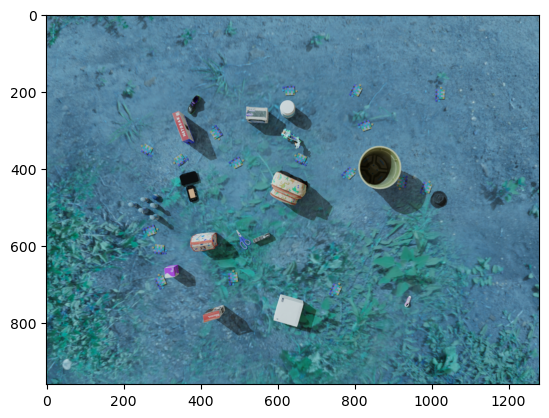

In [7]:
import cv2
import matplotlib.pyplot as plt

import png
import numpy as np

import tensorflow as tf
import tensorflow_datasets.public_api as tfds

def as_path(path) -> tfds.core.ReadWritePath:
  """Convert str or pathlike object to tfds.core.ReadWritePath.

  Instead of pathlib.Paths, we use the TFDS path because they transparently
  support paths to GCS buckets such as "gs://kubric-public/GSO".
  """
  return tfds.core.as_path(path)

def read_png(filename, rescale_range=None) -> np.ndarray:
  filename = as_path(filename)
  png_reader = png.Reader(bytes=filename.read_bytes())
  width, height, pngdata, info = png_reader.read()
  del png_reader

  bitdepth = info["bitdepth"]
  if bitdepth == 8:
    dtype = np.uint8
  elif bitdepth == 16:
    dtype = np.uint16
  else:
    raise NotImplementedError(f"Unsupported bitdepth: {bitdepth}")

  plane_count = info["planes"]
  pngdata = np.vstack(list(map(dtype, pngdata)))
  if rescale_range is not None:
    minv, maxv = rescale_range
    pngdata = pngdata / 2**bitdepth * (maxv - minv) + minv

  return pngdata.reshape((height, width, plane_count))


data_dir = '../external/my_kubric/output/train/00000000/'
img = cv2.imread(f'{data_dir}/rgba_00000.png')
segm = read_png(f'{data_dir}/segmentation_00000.png')

plt.imshow(img)

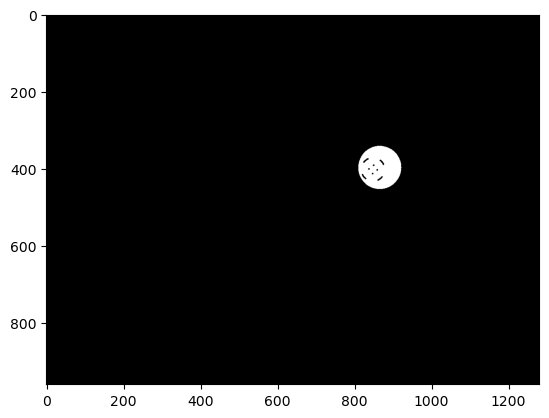

In [8]:
import numpy as np
unique_ids = np.unique(segm)

plt.imshow((segm==unique_ids[1]).astype(np.uint8) * 255, cmap='gray')

In [9]:
import json

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)
    
def save_json(file_path, data):
    with open(file_path, 'w') as f:
        json.dump(data, f)

metadata = load_json(f'{data_dir}/metadata.json')

In [10]:
from pydantic import BaseModel
from typing import List

class Instance(BaseModel):
    angular_velocities: List[List[float]]
    asset_id: str
    bbox_frames: List[int]
    bboxes: List[List[float]]
    bboxes_3d: List[List[List[float]]]
    category: str
    description: str
    friction: float
    image_positions: List[List[float]]
    mass: float
    nr_faces: int
    nr_vertices: int
    positions: List[List[float]]
    quaternions: List[List[float]]
    restitution: float
    surface_area: float
    velocities: List[List[float]]
    visibility: List[int]
    volume: float

    def __str__(self):
        return '\n'.join(f'{k}: {v}' for k, v in self.dict().items())

    def __repr__(self):
        return '\n'.join(f'{k}: {v}' for k, v in self.dict().items())
    
    def get_angle(self):
        """
        Convert quaternion to angle.
        Object is rotated around the z-axis, so we only need to consider the z-component of the quaternion.
        """
        # クオータニオンから要素を取り出す
        a, _, _, b = self.quaternions[0]

        # クオータニオンから角度を取得
        angle = 2 * math.atan2(b, a) * -1

        # 角度をdegreeに変換
        angle = math.degrees(angle)
        
        return angle

        
    
instances = [Instance(**json_dict) for json_dict in metadata['instances']]

In [11]:
instances[0]

angular_velocities: [[0.0, 0.0, 0.0]]
asset_id: Ecoforms_Garden_Pot_GP16ATurquois
bbox_frames: [0]
bboxes: [[0.35625, 0.63359375, 0.47291666666666665, 0.72109375]]
bboxes_3d: [[[-6.220331923186172, -0.6878192984869516, -3.5797270481197074e-08], [-6.220331923186172, -0.6878192984869516, 2.3726825682897896], [-3.8173730145992346, -0.4423583191165288, -3.5797270481197074e-08], [-3.8173730145992346, -0.4423583191165288, 2.3726825682897896], [-5.97441584517588, -3.09523342978898, -3.5797270481197074e-08], [-5.97441584517588, -3.09523342978898, 2.3726825682897896], [-3.571456936588943, -2.849772450418557, -3.5797270481197074e-08], [-3.571456936588943, -2.849772450418557, 2.3726825682897896]]]
category: None
description: Ecoforms Garden Pot, GP16A-Turquois
friction: 0.5
image_positions: [[0.6693840026855469, 0.4163177013397217]]
mass: 0.0001597794837694265
nr_faces: 9126
nr_vertices: 4863
positions: [[-4.872437000274658, -1.8053804636001587, 1.2343705892562866]]
quaternions: [[-0.742165982723

In [12]:
unique_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34], dtype=uint8)

In [13]:
metadata['metadata']

{'background': 'sunflowers',
 'frame_rate': 12,
 'gravity': [0.0, 0.0, -10.0],
 'num_frames': 1,
 'num_instances': 34,
 'resolution': [1280, 960],
 'seed': 304266624,
 'step_rate': 240}

In [9]:
# from models.v2 import build_yolox_backbone
# from models.yolox_models.darknet import CSPDarknet
# depth = 0.33
# width = 0.50
# model = CSPDarknet(depth, width, out_features=("stem", "dark2", "dark3", "dark4", "dark5"))
# model = model.cuda()
# model = model.eval()

# import torch

# x = torch.randn(1, 3, 640, 640).cuda()
# with torch.no_grad():
#     out = model(x)

In [14]:
from pydantic import BaseModel, validator
import torch

class Input(BaseModel):
    support_image: torch.Tensor
    support_annotation: torch.Tensor
    query_image: torch.Tensor
    query_annotation: torch.Tensor

    class Config:
        arbitrary_types_allowed = True

    @validator('support_image', 'query_image')
    def validate_shape(cls, v: torch.Tensor):
        if v.ndim != 4 or v.shape[0] != 1 or v.shape[1] != 3:
            raise ValueError('Tensor must be of shape (1, 3, H, W)')
        return v

    @validator('support_annotation', 'query_annotation')
    def validate_shape(cls, v: torch.Tensor):
        if v.ndim != 3 or v.shape[0] != 1 or v.shape[-1] != 5:
            raise ValueError('Tensor must be of shape (1, N, 5)')
        return v

In [15]:
image_input = Input(
    support_image=torch.randn(1, 3, 640, 640),
    support_annotation=torch.randn(1, 1, 5),
    query_image=torch.randn(1, 3, 640, 640),
    query_annotation=torch.randn(1, 1, 5),
)

In [16]:
B, N, _ = image_input.query_annotation.shape
query_labels = torch.zeros((B, N), dtype=torch.long)

# augment positive samples
all_query_annotations = []
all_query_labels = []
for dx in [-1, 0, -1]:
    for dy in [-1, 0, -1]:
        query_annotations = image_input.query_annotation.clone()
        query_labels = torch.ones((B, N), dtype=torch.long)
        query_annotations[..., 0] += dx
        query_annotations[..., 1] += dy
        all_query_annotations.append(query_annotations)
        all_query_labels.append(query_labels)

query_annotations = torch.cat(all_query_annotations, dim=1)
query_labels = torch.cat(all_query_labels, dim=1)

# generate negative samples
all_query_annotations = [query_annotations.clone()]
all_query_labels = [query_labels.clone()]
for da in range(15, 360, 15):
    query_annotations = query_annotations.clone()
    query_labels = torch.zeros_like(query_labels)
    query_annotations[..., 4] += da
    all_query_annotations.append(query_annotations)
    all_query_labels.append(query_labels)

query_annotations = torch.cat(all_query_annotations, dim=1)
query_labels = torch.cat(all_query_labels, dim=1)

print(query_annotations.shape)
print(query_labels.shape)

torch.Size([1, 216, 5])
torch.Size([1, 216])


In [25]:
from roi_align import RoIAlignFeatureExtractor

def add_batch_dim(tensor: torch.Tensor) -> torch.Tensor:
    batch_index = torch.zeros((len(tensor), 1)).to(tensor)
    return torch.cat([batch_index, tensor], dim=-1)

support_width, support_height = 10, 10
image_input.support_annotation = torch.tensor([[100, 100, support_width, support_height, 0]])[None].float()
rois = add_batch_dim(image_input.support_annotation[0])
roi_feature_extractor = RoIAlignFeatureExtractor(output_size=(support_width, support_height), sampling_ratio=2)
template_image = roi_feature_extractor.extract(image_input.support_image, rois, spatial_scale=1.0)

In [23]:
image_input.support_annotation.shape

torch.Size([1, 5])